In [2]:
import os
import timm
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Modules Loaded")

Modules Loaded


In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/oasis-dataset/input'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

labels = np.array([label for _, label in dataset.samples])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_val_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

labels_train_val = labels[train_val_idx]
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss_train_val.split(np.zeros(len(labels_train_val)), labels_train_val))

train_dataset = Subset(dataset, train_val_idx[train_idx])
val_dataset = Subset(dataset, train_val_idx[val_idx])
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print('Data loaded')

Data loaded


In [4]:
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import torch.nn.functional as F

class CBAM(torch.nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.max_pool = torch.nn.AdaptiveMaxPool2d(1)
        self.fc1 = torch.nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.fc2 = torch.nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1)
        
        self.conv = torch.nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        
        avg_out = self.fc2(F.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(F.relu(self.fc1(self.max_pool(x))))
        channel_att = torch.sigmoid(avg_out + max_out)
        x = x * channel_att
        
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        
        return x * spatial_att

In [5]:
from torchvision.models import MobileNet_V2_Weights
class MobileNetV2_Attention(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_Attention, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        
        for name, module in self.mobilenet.features.named_children():
            if isinstance(module, torch.nn.Conv2d):
                channels = module.out_channels
                setattr(self.mobilenet.features, name, torch.nn.Sequential(module, CBAM(channels)))
        
        self.mobilenet.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.mobilenet(x)

model = MobileNetV2_Attention(num_classes=4).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 15.0MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

early_stop_patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    global early_stop_counter, best_val_loss
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate_model(model, val_loader)
        
        train_losses.append(running_loss / total)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/total:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered! Training halted.")
            break

    return model

In [7]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / total

In [8]:
def evaluate_model_with_metrics(model, loader, dataset):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report:\n", report)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

In [9]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, epochs=10)

100%|██████████| 166/166 [00:25<00:00,  6.58it/s]


Epoch 1/10, Loss: 0.0298, Train Accuracy: 0.6171, Val Accuracy: 0.7630, LR: 0.0001


100%|██████████| 166/166 [00:19<00:00,  8.50it/s]


Epoch 2/10, Loss: 0.0245, Train Accuracy: 0.6707, Val Accuracy: 0.7720, LR: 0.0001


100%|██████████| 166/166 [00:19<00:00,  8.44it/s]


Epoch 3/10, Loss: 0.0123, Train Accuracy: 0.8496, Val Accuracy: 0.8758, LR: 0.0001


100%|██████████| 166/166 [00:19<00:00,  8.34it/s]


Epoch 4/10, Loss: 0.0075, Train Accuracy: 0.9160, Val Accuracy: 0.9338, LR: 0.0001


100%|██████████| 166/166 [00:20<00:00,  8.18it/s]


Epoch 5/10, Loss: 0.0051, Train Accuracy: 0.9396, Val Accuracy: 0.9729, LR: 0.0001


100%|██████████| 166/166 [00:20<00:00,  7.98it/s]


Epoch 6/10, Loss: 0.0023, Train Accuracy: 0.9752, Val Accuracy: 0.9624, LR: 0.0001
Early stopping counter: 1/5


100%|██████████| 166/166 [00:21<00:00,  7.78it/s]


Epoch 7/10, Loss: 0.0015, Train Accuracy: 0.9855, Val Accuracy: 0.9917, LR: 0.0001


100%|██████████| 166/166 [00:21<00:00,  7.71it/s]


Epoch 8/10, Loss: 0.0013, Train Accuracy: 0.9878, Val Accuracy: 0.9804, LR: 0.0001
Early stopping counter: 1/5


100%|██████████| 166/166 [00:21<00:00,  7.84it/s]


Epoch 9/10, Loss: 0.0008, Train Accuracy: 0.9913, Val Accuracy: 0.9255, LR: 0.0001
Early stopping counter: 2/5


100%|██████████| 166/166 [00:21<00:00,  7.83it/s]


Epoch 10/10, Loss: 0.0016, Train Accuracy: 0.9814, Val Accuracy: 0.9925, LR: 0.0001


In [10]:
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

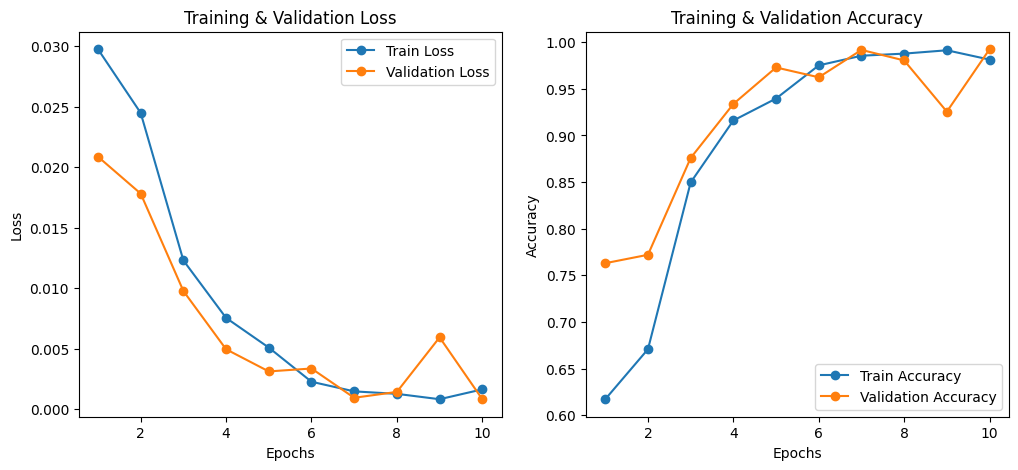

In [11]:
plot_metrics()

Classification Report:
                     precision    recall  f1-score   support

     Mild Dementia       1.00      0.99      0.99       900
 Moderate Dementia       0.99      1.00      0.99       147
      Non Demented       1.00      0.99      0.99       900
Very mild Dementia       0.98      1.00      0.99       900

          accuracy                           0.99      2847
         macro avg       0.99      0.99      0.99      2847
      weighted avg       0.99      0.99      0.99      2847



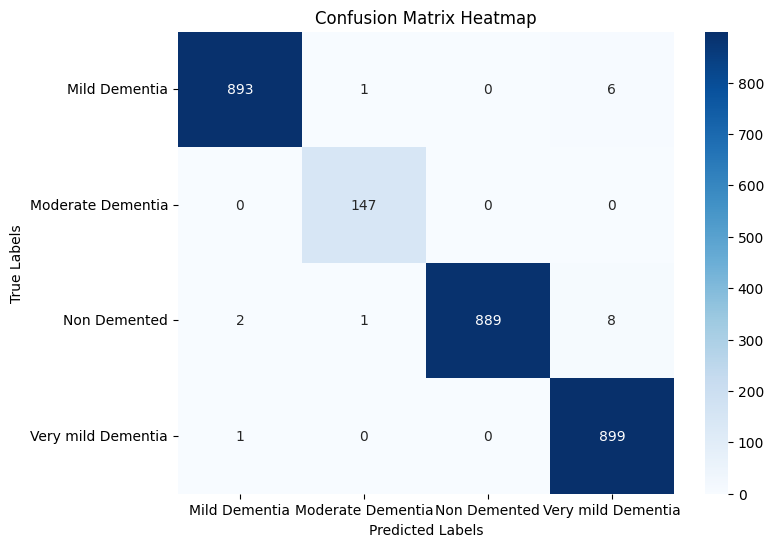

In [12]:
evaluate_model_with_metrics(trained_model, test_loader, dataset)

In [13]:
torch.save(trained_model.state_dict(), "trained_mobilenetv2_cbam.pth")

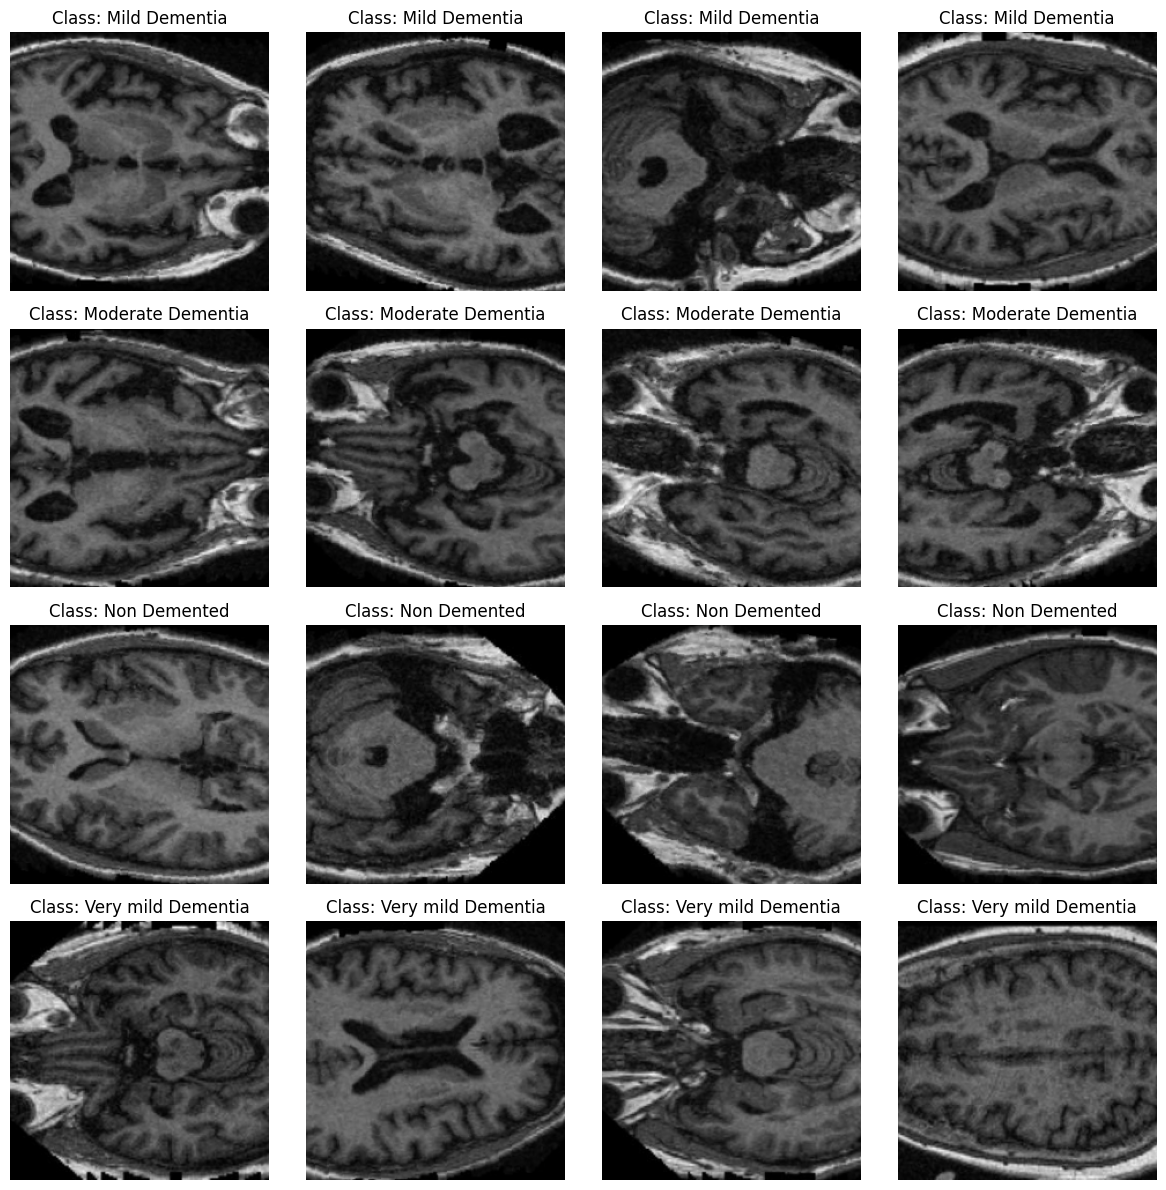

In [14]:
import random
from collections import defaultdict

classwise_samples = defaultdict(list)

for idx in range(len(dataset)):
    image, label = dataset[idx]
    classwise_samples[label].append(image)

num_classes = len(dataset.classes)
selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    images = classwise_samples[class_idx]
    selected_images.extend(random.sample(images, min(4, len(images))))
    selected_labels.extend([class_idx] * min(4, len(images)))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, (image, label) in enumerate(zip(selected_images, selected_labels)):
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    axes[idx].imshow(image_np)
    axes[idx].axis("off")
    axes[idx].set_title(f"Class: {dataset.classes[label]}")

plt.tight_layout()
plt.show()

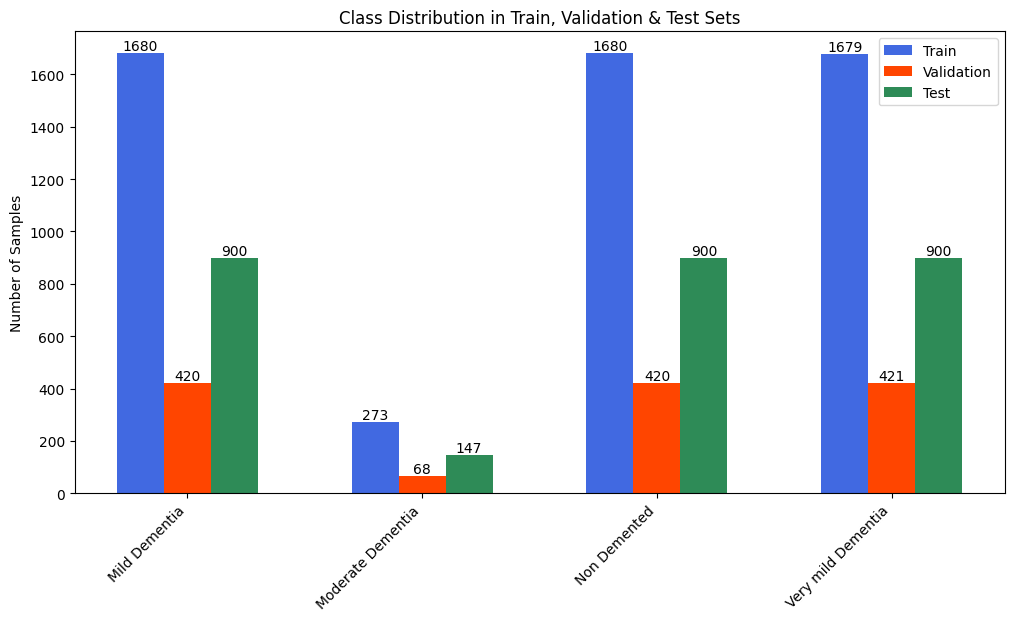

In [15]:
from collections import Counter

train_labels = [dataset.targets[idx] for idx in train_val_idx[train_idx]]
val_labels = [dataset.targets[idx] for idx in train_val_idx[val_idx]]
test_labels = [dataset.targets[idx] for idx in test_idx]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

classes = dataset.classes
x = np.arange(len(classes))

plt.figure(figsize=(12, 6))

train_bars = plt.bar(x - 0.2, [train_counts[i] for i in range(len(classes))], width=0.2, label="Train", color="royalblue")
val_bars = plt.bar(x, [val_counts[i] for i in range(len(classes))], width=0.2, label="Validation", color="orangered")
test_bars = plt.bar(x + 0.2, [test_counts[i] for i in range(len(classes))], width=0.2, label="Test", color="seagreen")

for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

for bar in val_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

plt.xticks(ticks=x, labels=classes, rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train, Validation & Test Sets")
plt.legend()
plt.show()

In [16]:
trained_model = MobileNetV2_Attention(num_classes=4).to(device)
trained_model.load_state_dict(torch.load("trained_mobilenetv2_cbam.pth", map_location=device))
trained_model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [17]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None  
        
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()

        output[:, target_class].backward()
        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.sum(weights[:, :, None, None] * activations, axis=1)
        cam = np.maximum(cam, 0)  
        cam -= cam.min()
        cam /= cam.max()

        return cv2.resize(cam[0], (input_tensor.shape[-1], input_tensor.shape[-2]))

target_layer = model.mobilenet.features[-3]
grad_cam = GradCAM(model, target_layer)

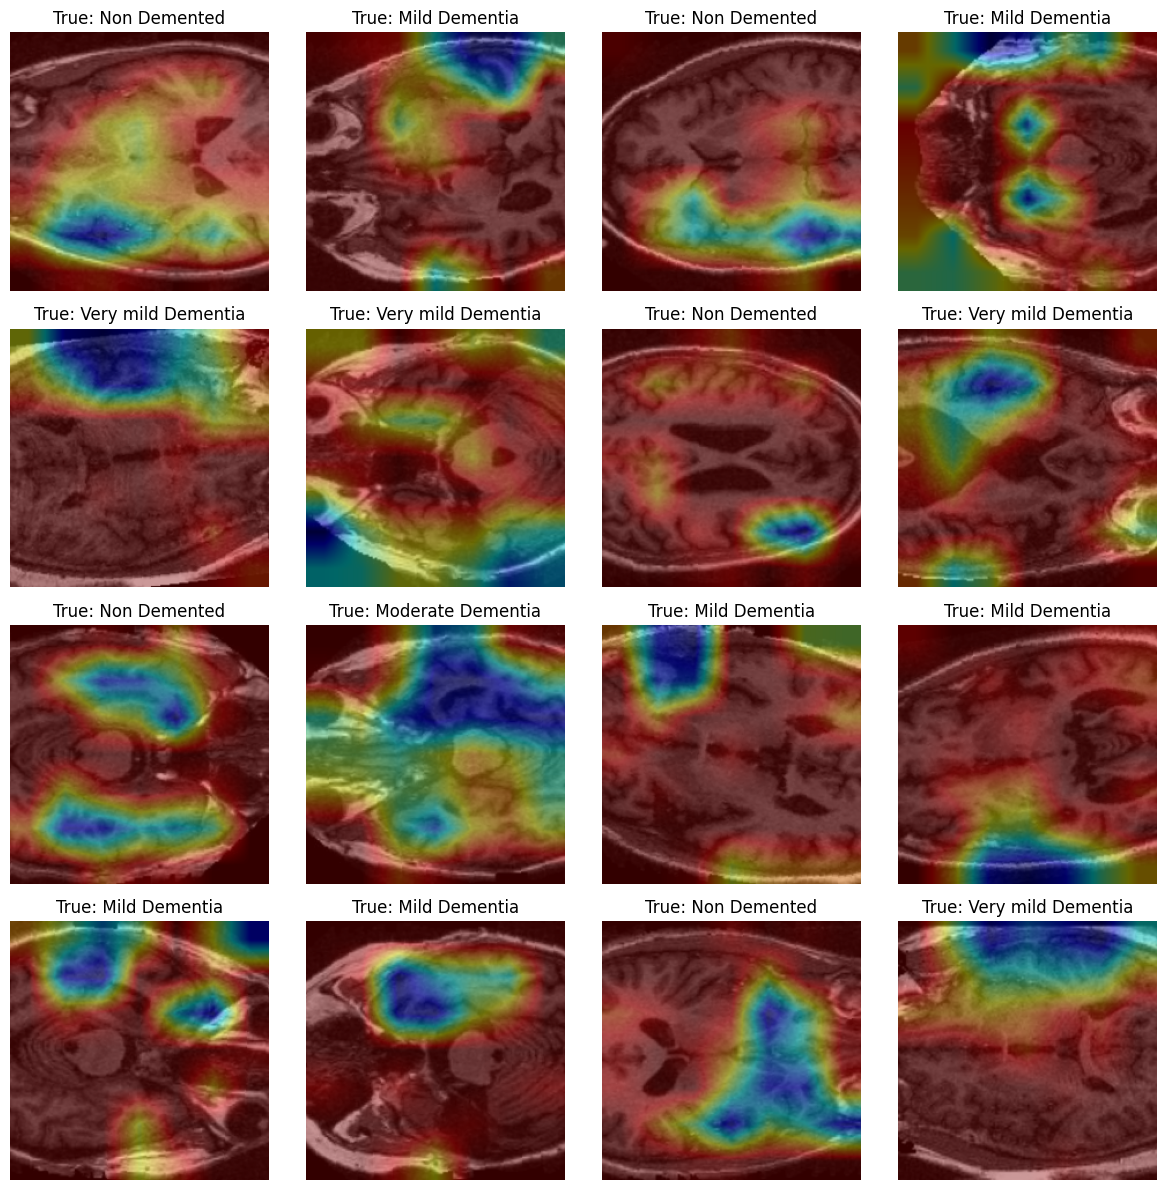

In [18]:
import cv2

num_images = 16

test_images, test_labels = next(iter(test_loader))
test_images = test_images[:num_images].to(device)
test_labels = test_labels[:num_images].to(device)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, image in enumerate(test_images):
    input_tensor = image.unsqueeze(0)
    target_class = torch.argmax(model(input_tensor))
    heatmap = grad_cam.generate_heatmap(input_tensor, target_class.item())
    
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = ((image_np * std) + mean) * 255
    image_np = np.clip(image_np, 0, 255).astype(np.uint8)
    
    heatmap_overlay = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    overlayed_image = cv2.addWeighted(image_np, 0.6, heatmap_overlay, 0.4, 0)
    
    axes[idx].imshow(overlayed_image)
    axes[idx].axis("off")
    axes[idx].set_title(f"True: {dataset.classes[test_labels[idx].item()]}")

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

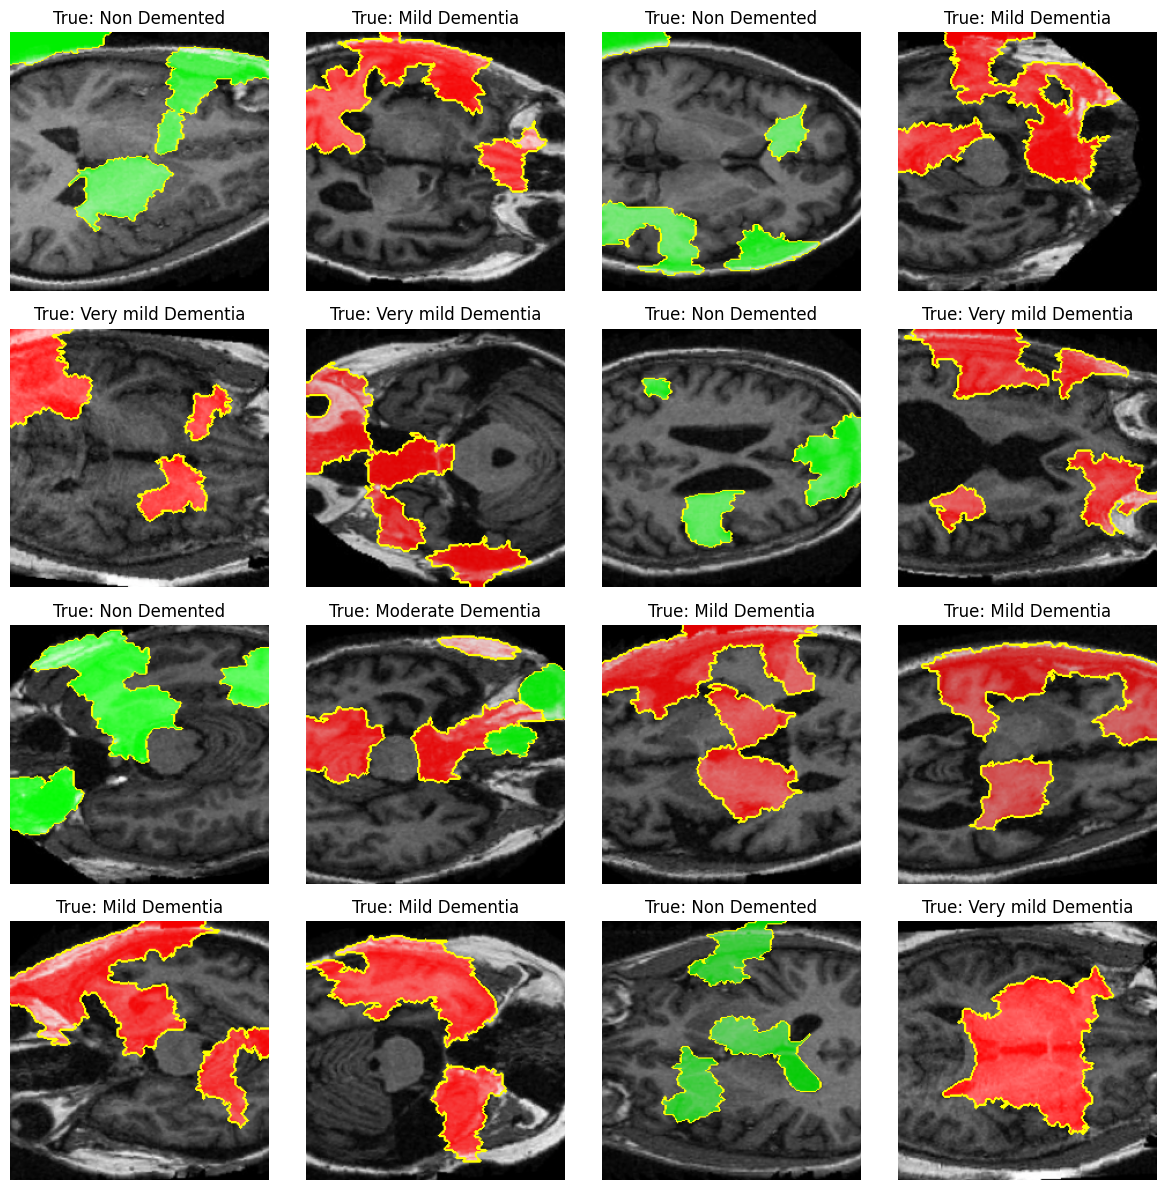

In [19]:
import lime
import lime.lime_image
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

explainer = lime.lime_image.LimeImageExplainer()

def predict_fn(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
    outputs = model(images)
    return torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()

num_images = 16

test_images, test_labels = next(iter(test_loader))
test_images = test_images[:num_images]
test_labels = test_labels[:num_images]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, image in enumerate(test_images):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = ((image_np * std) + mean)
    
    explanation = explainer.explain_instance(image_np, predict_fn, labels=(0, 1, 2, 3), hide_color=0, num_samples=1000)
    
    target_class = torch.argmax(model(image.unsqueeze(0).to(device))).item()
    temp, mask = explanation.get_image_and_mask(target_class, positive_only=False, hide_rest=False)
    
    axes[idx].imshow(mark_boundaries(temp, mask))
    axes[idx].axis("off")
    axes[idx].set_title(f"True: {dataset.classes[test_labels[idx].item()]}")

plt.tight_layout()
plt.show()

In [20]:
import torch
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/oasis-dataset/input'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [21]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1)
        
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        
        avg_out = self.fc2(nn.ReLU()(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(nn.ReLU()(self.fc1(self.max_pool(x))))
        channel_att = torch.sigmoid(avg_out + max_out)
        x = x * channel_att
        
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        
        return x * spatial_att

class MobileNetV2_CBAM(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_CBAM, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        for name, module in self.mobilenet.features.named_children():
            if isinstance(module, nn.Conv2d):
                channels = module.out_channels
                setattr(self.mobilenet.features, name, nn.Sequential(module, CBAM(channels)))
                
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.mobilenet(x)

mobilenet_cbam = MobileNetV2_CBAM(num_classes=4)
mobilenet_cbam.load_state_dict(torch.load("/kaggle/working/trained_mobilenetv2_cbam.pth", map_location=device))

mobilenet_cbam.mobilenet.classifier = nn.Identity()

In [22]:
mobilenet_cbam.to(device)
mobilenet_cbam.eval()

features_list = []
labels_list = []

with torch.inference_mode():
    for images, labels in tqdm(data_loader):
        images = images.to(device)

        feature_vectors = mobilenet_cbam(images)
        features_list.extend(feature_vectors.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

100%|██████████| 297/297 [00:26<00:00, 11.32it/s]


In [23]:
features_df.to_csv("/kaggle/working/trained_mobilenet_cbam_features.csv", index=False)
print("Feature extraction complete! Saved as trained_mobilenet_cbam_features.csv")

Feature extraction complete! Saved as trained_mobilenet_cbam_features.csv


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

print('Modules loaded')

Modules loaded


In [17]:
df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.7, random_state=42))
test_df = df_shuffled.drop(train_df.index)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

print('Dataset Loaded')

Dataset Loaded


/tmp/ipykernel_35/2890742673.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.7, random_state=42))


In [18]:
def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()

    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

In [19]:
feature_entropies = {feature: renyi_entropy(X_train[feature].values, alpha=2) for feature in X_train.columns}

sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)

top_features = sorted_features[:80]

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print('Top K-features Selected')

Top K-features Selected


In [20]:
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

In [21]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)

print('Model Training and Inference Done')

Model Training and Inference Done


Voting Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900

    accuracy                           1.00      2846
   macro avg       1.00      1.00      1.00      2846
weighted avg       1.00      1.00      1.00      2846

Accuracy: 0.9989
Precision (Weighted): 0.9989
Recall (Weighted): 0.9989
F1 Score (Weighted): 0.9989


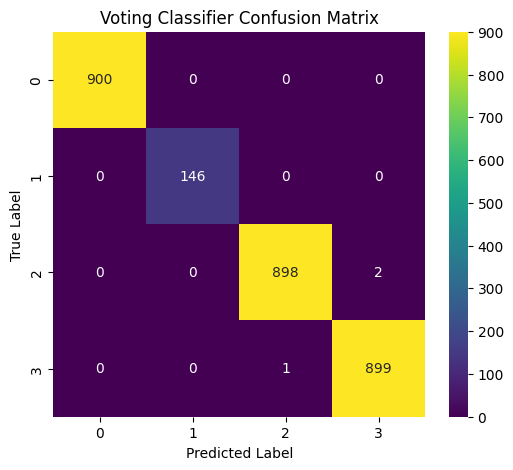

In [22]:
print("Voting Classifier Classification Report:\n", classification_report(y_test, y_pred_voting))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting, average='weighted')
recall = recall_score(y_test, y_pred_voting, average='weighted')
f1 = f1_score(y_test, y_pred_voting, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, cmap='viridis', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

Features: 10, Accuracy: 97.08%
Features: 15, Accuracy: 98.49%
Features: 20, Accuracy: 99.26%
Features: 25, Accuracy: 99.37%
Features: 30, Accuracy: 99.47%
Features: 35, Accuracy: 99.51%
Features: 40, Accuracy: 99.44%
Features: 45, Accuracy: 99.54%
Features: 50, Accuracy: 99.68%
Features: 55, Accuracy: 99.72%
Features: 60, Accuracy: 99.72%
Features: 65, Accuracy: 99.82%
Features: 70, Accuracy: 99.86%
Features: 75, Accuracy: 99.86%
Features: 80, Accuracy: 99.89%
Features: 85, Accuracy: 99.82%
Features: 90, Accuracy: 99.89%
Features: 95, Accuracy: 99.89%
Features: 100, Accuracy: 99.89%


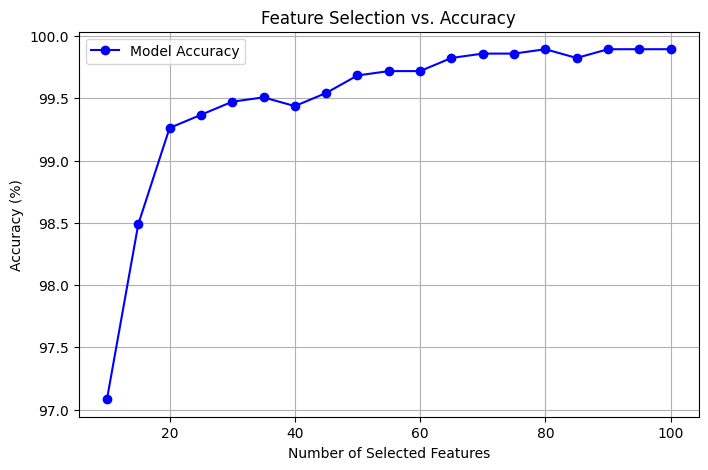

In [15]:
import matplotlib.pyplot as plt

feature_counts = [10, 15, 20, 25, 30, 35,
                  40, 45, 50, 55, 60, 65,
                  70, 75, 80, 85, 90, 95,100]
accuracies = []

for num_features in feature_counts:
    
    top_features = sorted_features[:num_features]
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)
    
    voting_clf.fit(X_train_selected, y_train)
    y_pred_voting = voting_clf.predict(X_test_selected)
    
    accuracy = voting_clf.score(X_test_selected, y_test) * 100
    accuracies.append(accuracy)
    print(f"Features: {num_features}, Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o', linestyle='-', color='b', label="Model Accuracy")
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy (%)")
plt.title("Feature Selection vs. Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

X, y = df_shuffled.drop(columns=['label']), df_shuffled['label']

def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()
    
    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

feature_entropies = {feature: renyi_entropy(X[feature].values, alpha=2) for feature in X.columns}

sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)

top_features = sorted_features[:80]

X_selected = X[top_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

         accuracy  precision  recall  f1-score
Average    0.9987     0.9987  0.9987    0.9987


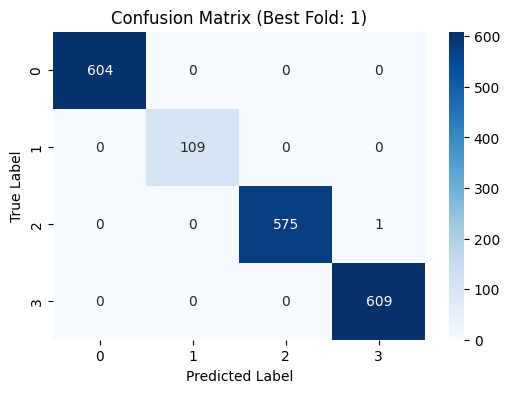

Classification Report (Best Fold: 1):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       604
           1       1.00      1.00      1.00       109
           2       1.00      1.00      1.00       576
           3       1.00      1.00      1.00       609

    accuracy                           1.00      1898
   macro avg       1.00      1.00      1.00      1898
weighted avg       1.00      1.00      1.00      1898



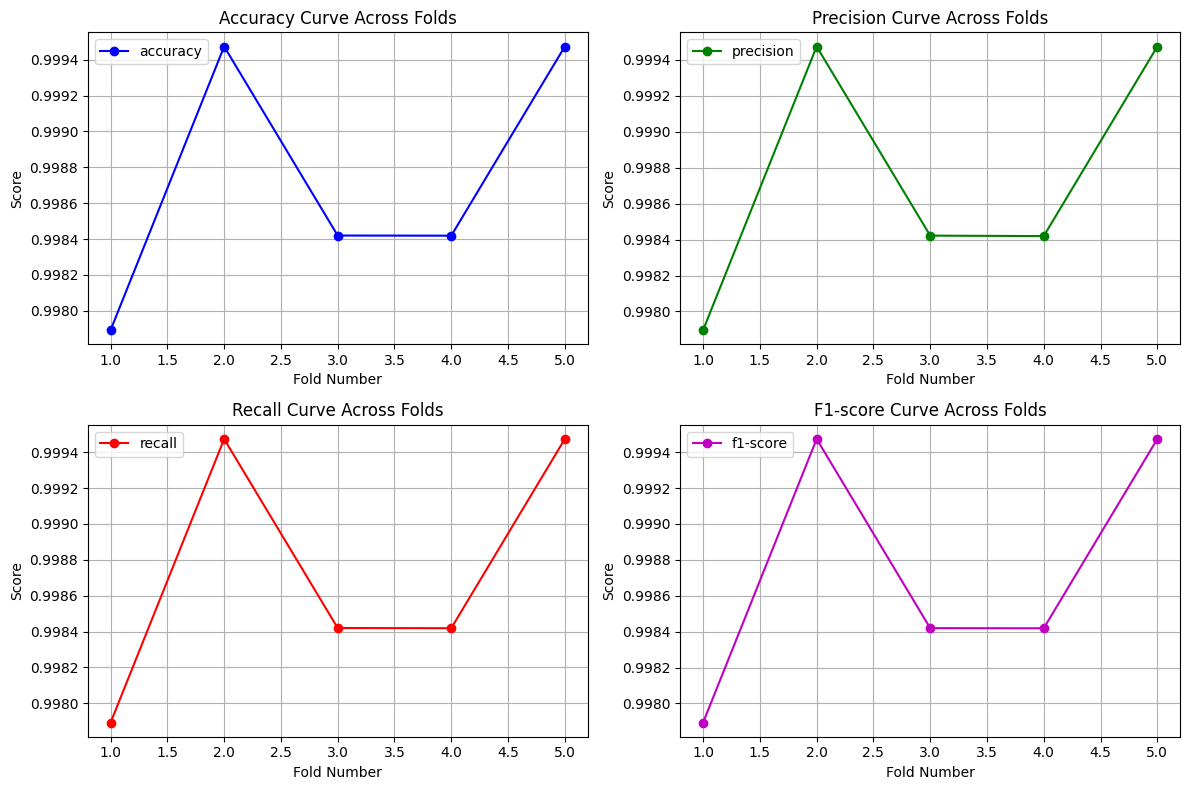

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1-score': []}
best_fold = {'index': None, 'accuracy': 0, 'y_true': None, 'y_pred': None}

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1-score'].append(f1)
    
    if acc > best_fold['accuracy']:
        best_fold.update({'index': fold, 'accuracy': acc, 'y_true': y_test, 'y_pred': y_pred})

average_metrics = {key: np.mean(values) for key, values in metrics.items()}
print(pd.DataFrame(average_metrics, index=['Average']).round(4))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(best_fold['y_true'], best_fold['y_pred']), annot=True, cmap='Blues', fmt='d')
plt.title(f"Confusion Matrix (Best Fold: {best_fold['index']})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Classification Report (Best Fold: {best_fold['index']}):\n")
print(classification_report(best_fold['y_true'], best_fold['y_pred']))

plt.figure(figsize=(12, 8))

metrics_list = ['accuracy', 'precision', 'recall', 'f1-score']
colors = ['b', 'g', 'r', 'm']

for i, metric in enumerate(metrics_list):
    plt.subplot(2, 2, i+1)
    plt.plot(range(1, 6), metrics[metric], marker='o', color=colors[i], label=metric)
    plt.title(f"{metric.capitalize()} Curve Across Folds")
    plt.xlabel("Fold Number")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Modules loaded


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Dataset Loaded
Top K-features Selected
Model Training and Inference Done
Voting Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600

    accuracy                           1.00      1898
   macro avg       1.00      1.00      1.00      1898
weighted avg       1.00      1.00      1.00      1898



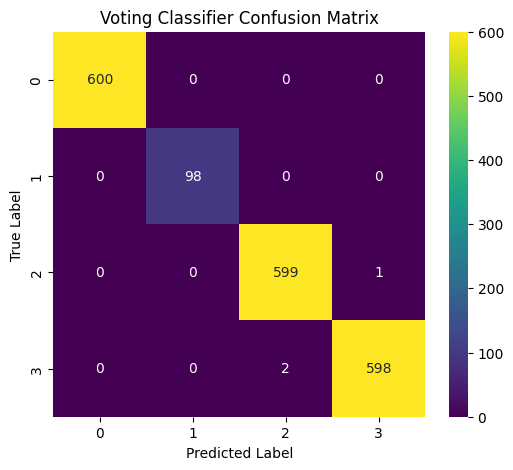

Applying SHAP KernelExplainer...


  0%|          | 0/25 [00:00<?, ?it/s]

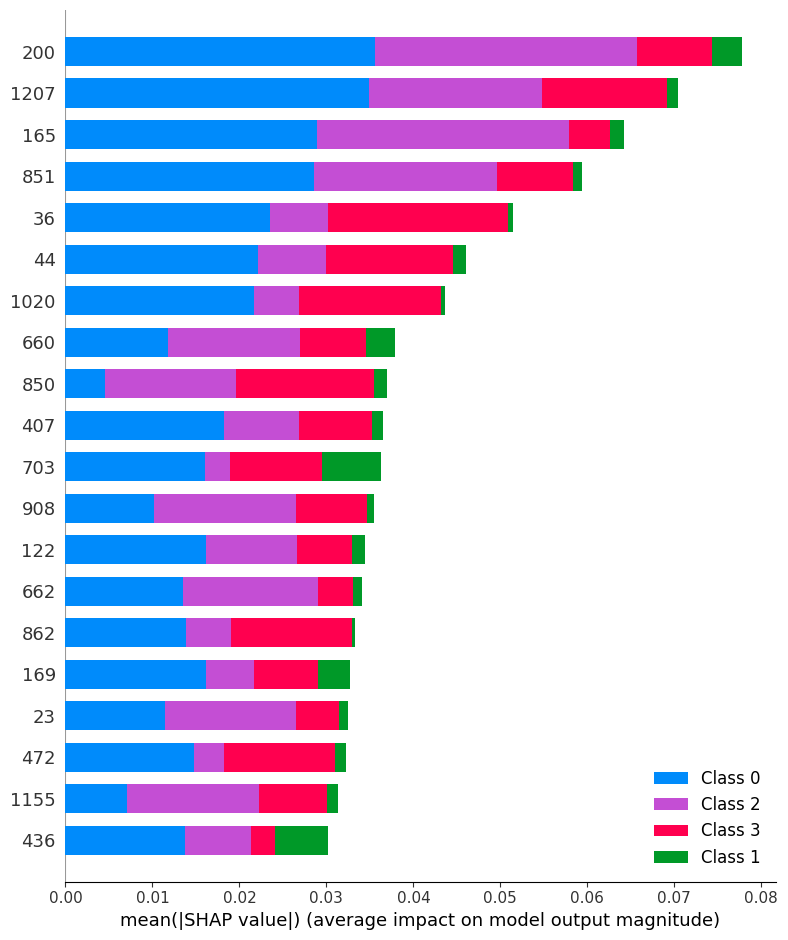

SHAP analysis completed!


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

print('Modules loaded')

df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.8, random_state=42))
test_df = df_shuffled.drop(train_df.index)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

print('Dataset Loaded')

def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()

    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

feature_entropies = {feature: renyi_entropy(X_train[feature].values, alpha=2) for feature in X_train.columns}
sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)
top_features = sorted_features[:80]

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print('Top K-features Selected')

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)

print('Model Training and Inference Done')

print("Voting Classifier Classification Report:\n", classification_report(y_test, y_pred_voting))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, cmap='viridis', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

print("Applying SHAP KernelExplainer...")

explainer = shap.KernelExplainer(voting_clf.predict_proba, X_train_selected[:25])

shap_values = explainer.shap_values(X_test_selected[:25])

shap.summary_plot(shap_values, X_test_selected[:25], feature_names=top_features)

print("SHAP analysis completed!")